Direct Regression Nutrition Prediction

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd 'drive/MyDrive/CV_2024/FinalProject/nutri_estimate/nutri_estimate/nutrition_model'
%pwd

/content/drive/MyDrive/CV_2024/FinalProject/nutri_estimate/nutri_estimate/nutrition_model


'/content/drive/MyDrive/CV_2024/FinalProject/nutri_estimate/nutri_estimate/nutrition_model'

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import efficientnet_v2_s
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from PIL import Image
import os
import joblib

# GPU availability
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [4]:
filepath = '../preprocess/filtered_data.json'

df = pd.read_json(
    filepath,
    dtype={'total_mass': 'float64'}
)
df.head(3)

,id,total_calories,total_mass,total_fat,total_carb,total_protein,label,image_link,split
0,dish_1561662216,300.794281,193.0,12.387489,28.21829,18.63397,"[brown rice, pork, mixed greens]",./data/dish_1561662216/camera_A_frame_002.jpeg,test
1,dish_1561662216,300.794281,193.0,12.387489,28.21829,18.63397,"[brown rice, pork, mixed greens]",./data/dish_1561662216/camera_D_frame_002.jpeg,test
2,dish_1561662216,300.794281,193.0,12.387489,28.21829,18.63397,"[brown rice, pork, mixed greens]",./data/dish_1561662216/camera_C_frame_002.jpeg,test


In [5]:
from sklearn.preprocessing import MinMaxScaler

# Scale target columns
scalers = {}
for col in ['total_calories', 'total_mass', 'total_fat', 'total_carb', 'total_protein']:
    scaler = MinMaxScaler()
    df[col] = scaler.fit_transform(df[[col]])
    scalers[col] = scaler

# Save scalers for inverse transformation later
import joblib
for col, scaler in scalers.items():
    joblib.dump(scaler, f'./scalers/{col}_scaler.save')

In [6]:
df.head(3)

,id,total_calories,total_mass,total_fat,total_carb,total_protein,label,image_link,split
0,dish_1561662216,0.348849,0.311987,0.182478,0.187726,0.154563,"[brown rice, pork, mixed greens]",./data/dish_1561662216/camera_A_frame_002.jpeg,test
1,dish_1561662216,0.348849,0.311987,0.182478,0.187726,0.154563,"[brown rice, pork, mixed greens]",./data/dish_1561662216/camera_D_frame_002.jpeg,test
2,dish_1561662216,0.348849,0.311987,0.182478,0.187726,0.154563,"[brown rice, pork, mixed greens]",./data/dish_1561662216/camera_C_frame_002.jpeg,test


In [7]:
# Split dataset
def split_data(df):
    X_train = df[df['split'] == 'train']
    X_test = df[df['split'] == 'test']
    return X_train, X_test

X_train, X_test = split_data(df)

In [8]:
from torch.utils.data import Dataset

class NutritionDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = os.path.join(self.root_dir, row['image_link'])
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Get labels
        labels = {
            'protein': row['total_protein'],
            'fat': row['total_fat'],
            'carbs': row['total_carb'],
            'mass': row['total_mass']
        }
        return image, labels

In [9]:
# Define image transformations (standardise 320, 320)
transform = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.ToTensor()
])

# Datasets and dataloaders for training and testing
root_dir = '../preprocess'
train_dataset = NutritionDataset(X_train, root_dir, transform=transform)
test_dataset = NutritionDataset(X_test, root_dir, transform=transform)

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [10]:
class EfficientNetBase(nn.Module):
    def __init__(self):
        super(EfficientNetBase, self).__init__()
        self.base_model = efficientnet_v2_s(weights=None)
        self.base_model.classifier = nn.Identity()  # here we remove classification head from our base model since we want to predict continuous nutrition vals

    def forward(self, x):
        return self.base_model(x)

state_dict = torch.load('/content/drive/MyDrive/CV_2024/FinalProject/nutri_estimate/nutri_estimate/efficientnet_image_model/finetuned_model/final_saved_model/model1.pth', map_location=device)

# Filter out keys related to the classification head
filtered_state_dict = {key: value for key, value in state_dict.items() if not key.startswith('base_model.classifier')}

base_model = EfficientNetBase()
base_model.load_state_dict(filtered_state_dict)

base_model = base_model.to(device)

<ipython-input-10-dff7e74177d4>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/content/drive/MyDrive/CV_2024/FinalProject/nutri_estimate/nutri_e

In [11]:
# Multi-task model
class MultiTaskModel(nn.Module):
    def __init__(self, base_model):
        super(MultiTaskModel, self).__init__()
        self.base_model = base_model
        in_features = 1280

        # Def separate branch for each task (each nutritional part)
        self.protein_branch = self._create_branch(in_features)
        self.fat_branch = self._create_branch(in_features)
        self.carbs_branch = self._create_branch(in_features)
        self.mass_branch = self._create_branch(in_features)

    def _create_branch(self, in_features):
        return nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.base_model(x)
        protein = self.protein_branch(x)
        fat = self.fat_branch(x)
        carbs = self.carbs_branch(x)
        mass = self.mass_branch(x)
        return {
            'protein': protein,
            'fat': fat,
            'carbs': carbs,
            'mass': mass
        }

# Initialise multi-task model
model = MultiTaskModel(base_model)
model = model.to(device)

In [ ]:
# Define loss function and optimizer
criterion = nn.MSELoss()  # MSE for regression tasks
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device).float()
        labels = {key: val.to(device).float() for key, val in labels.items()}

        optimizer.zero_grad()
        outputs = model(images)

        # Calculate total L (sum of individual task losses)
        loss = sum([criterion(outputs[key].squeeze(), labels[key]) for key in outputs])
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")

    torch.save(model.state_dict(), f"multi_task_model_epoch_{epoch+1}.pth")

Epoch 1, Loss: 0.015500404229589903
Epoch 2, Loss: 0.009145969868939174
Epoch 3, Loss: 0.006849822529578442
Epoch 4, Loss: 0.0055406596934129875
Epoch 5, Loss: 0.004703144403856386
Epoch 6, Loss: 0.004168383760382208
Epoch 7, Loss: 0.0037072362692855965
Epoch 8, Loss: 0.0034400386118554386
Epoch 9, Loss: 0.003156473373663411
Epoch 10, Loss: 0.0029139213879239064


In [ ]:
print(f"Test Dataset Size: {len(test_dataset)}")
print(f"Number of batches in Test Loader: {len(test_loader)}")

Test Dataset Size: 9677
Number of batches in Test Loader: 604


In [ ]:
# Eval loop
model.eval()
y_true, y_pred = {k: [] for k in ['protein', 'fat', 'carbs', 'mass']}, {k: [] for k in ['protein', 'fat', 'carbs', 'mass']}

with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = {key: val.to(device) for key, val in labels.items()}  # Move labels to device
        outputs = model(images)

        for key in outputs:
            # Debuggin (check if predictions and labels have matching sizes)
            if outputs[key].shape[0] != labels[key].shape[0]:
                print(f"Batch {i}: Mismatch in sizes for key '{key}' - "
                      f"Predictions: {outputs[key].shape}, Labels: {labels[key].shape}")
                continue  # Skip curr batch

            # Flatten labels and predictions (remove inconsistencies)
            y_pred[key].append(outputs[key].cpu().numpy().reshape(-1, 1))
            y_true[key].append(labels[key].cpu().numpy().reshape(-1, 1))

# Stack predictions and labels for each task
for key in y_pred:
    try:
        y_pred[key] = np.vstack(y_pred[key])
        y_true[key] = np.vstack(y_true[key])
    except ValueError as e:
        print(f"Error stacking for key '{key}': {e}")
        continue  # Skip the problematic key

# Debugging to print shapes after stacking (can remove after issue resolve)
for key in y_pred:
    if isinstance(y_pred[key], np.ndarray):
        print(f"{key} predictions shape (after stacking): {y_pred[key].shape}")
    if isinstance(y_true[key], np.ndarray):
        print(f"{key} true labels shape (after stacking): {y_true[key].shape}")

# Eval performance if stacking is ok
from sklearn.metrics import mean_absolute_error
for key in y_pred:
    if isinstance(y_pred[key], np.ndarray) and isinstance(y_true[key], np.ndarray):
        mae = mean_absolute_error(y_true[key], y_pred[key])
        print(f"{key.capitalize()} MAE: {mae}")

protein predictions shape (after stacking): (9664, 1)
protein true labels shape (after stacking): (9664, 1)
fat predictions shape (after stacking): (9664, 1)
fat true labels shape (after stacking): (9664, 1)
carbs predictions shape (after stacking): (9664, 1)
carbs true labels shape (after stacking): (9664, 1)
mass predictions shape (after stacking): (9664, 1)
mass true labels shape (after stacking): (9664, 1)
Protein MAE: 0.03735652994133777
Fat MAE: 0.04749919676947578
Carbs MAE: 0.030630207809346235
Mass MAE: 0.04901078318909881


<ipython-input-13-2d49e299ca1d>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, map_location=device)


Model loaded from multi_task_model_epoch_10.pth
Predicted Nutritional Breakdown: {'protein': 70.28576, 'fat': 20.25372, 'carbs': 36.440567, 'mass': 418.93857}


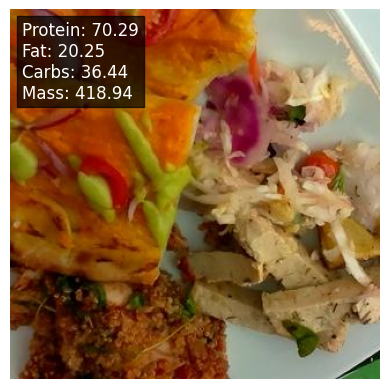

In [13]:
import torch
import matplotlib.pyplot as plt
from PIL import Image

# Load the last saved model from epoch 10
def load_saved_model(model, checkpoint_path):
    """
    Load the weights of a saved model checkpoint.
    """
    state_dict = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(state_dict)
    print(f"Model loaded from {checkpoint_path}")
    return model

# Single prediction example from random image
def predict_image(image_path, model):
    """
    Predict nutritional breakdown for a single image with clamped values.
    """
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)

    # Inverse transform predictions to reverse scaling that I prev added
    results = {}
    for key in outputs:
        # Adjust key naming to match the scalers dictionary (carbs don't match carb)
        scaler_key = f"total_{key[:-1]}" if key == "carbs" else f"total_{key}"
        if scaler_key in scalers:
            predicted_value = scalers[scaler_key].inverse_transform(outputs[key].cpu().numpy())[0][0]
            results[key] = max(0, predicted_value)
        else:
            print(f"Warning: Scaler for key '{scaler_key}' not found. Skipping inverse transformation.")
            results[key] = max(0, outputs[key].cpu().numpy()[0][0])  # use raw output as fallback(clamped)
    return results

def plot_image_with_predictions(image_path, predictions):
    """
    Plot the image and overlay the nutritional predictions.
    """
    image = Image.open(image_path).convert('RGB')
    plt.imshow(image)
    plt.axis('off')
    text = "\n".join([f"{key.capitalize()}: {value:.2f}" for key, value in predictions.items()])
    plt.text(
        10, 10, text,
        fontsize=12, color='white', bbox=dict(facecolor='black', alpha=0.7),
        ha='left', va='top'
    )
    plt.show()

# Load model from last epocj checkpoint
checkpoint_path = "multi_task_model_epoch_10.pth"
base_model = EfficientNetBase()
model = MultiTaskModel(base_model)
model = load_saved_model(model, checkpoint_path)
model = model.to(device)

# Test prediction
random_image_path = "../preprocess/" + X_test.sample(1)['image_link'].values[0]
image_path = random_image_path
prediction = predict_image(image_path, model)
print("Predicted Nutritional Breakdown:", prediction)

# Plot image with predictions
plot_image_with_predictions(image_path, prediction)